<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/ew_distributions_AHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# !pip install netCDF4
import xarray as xr
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from tqdm import tqdm
from scipy.stats import lognorm, linregress


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cb_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(3857)

In [5]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [6]:
ew_pts1 = gpd.read_file('/content/drive/MyDrive/platte_pts_10000m.shp')[['iindex', 'geometry']]
ew_circles1 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')[['iindex', 'geometry']]

ew_pts2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_20250918.shp')[['iindex', 'geometry']]
ew_circles2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp')[['iindex', 'geometry']]

ew_pts3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_extra.shp')[['iindex', 'geometry']]
ew_circles3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp')[['iindex', 'geometry']]


ew_pts = pd.concat([ew_pts1, ew_pts2, ew_pts3])
ew_pts = gpd.GeoDataFrame(ew_pts, geometry=ew_pts.geometry, crs=4326).to_crs(3857)

ew_circles = pd.concat([ew_circles1, ew_circles2, ew_circles3])
ew_circles = gpd.GeoDataFrame(ew_circles, geometry=ew_circles.geometry).to_crs(3857)
ew_pts = ew_pts.loc[(ew_pts.iindex.isin(ew_circles.iindex)) & (ew_pts.iindex != 30618)]

ew_circles['riv_length'] = ew_circles.apply(lambda x: gpd.sjoin(cb_centerlines, gpd.GeoDataFrame(geometry=[x.geometry], crs=3857)).length.sum(), axis=1)

ew_pts = pd.merge(ew_pts, ew_circles[['iindex', 'riv_length']])
ew_pts = ew_pts.to_crs(3857).sjoin_nearest(merit_centerlines, distance_col='distance_merit')[['iindex', 'geometry', 'riv_length', 'COMID', 'distance_merit', 'order']]

ew_pts = ew_pts.sjoin_nearest(cb_centerlines[['NewSO', 'geometry']], distance_col='distance_cb').drop_duplicates('iindex')

ew_pts

,iindex,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,38577,POINT (-11690505.247 4811857.209),81.082801,74038452,53.288151,4,4997,9,10.629683
1,33809,POINT (-11685635.215 4835085.32),136.538532,74038417,24.918905,4,2998,9,1.070429
2,34632,POINT (-11688434.826 4823704.536),125.759812,74038438,24.136813,4,3995,9,4.604104
3,40608,POINT (-11680394.88 4846335.545),122.568220,74038395,593.019014,4,2002,9,5.646844
4,37091,POINT (-11673614.76 4855615.592),302.318549,74038375,274.707401,4,1000,9,7.395028
...,...,...,...,...,...,...,...,...,...
472,107328,POINT (-10837835.026 5073919.205),937.874503,74029224,9.738052,5,223574,10,2.273456
473,244511,POINT (-11080725.027 4965503.779),1195.506855,74029167,3.425225,6,162885,12,2.794537
474,245153,POINT (-11083844.976 4964870.754),1217.410395,74030651,194.248106,2,368438,12,7.007301
475,246043,POINT (-10718194.959 5055774.457),496.596308,74029691,19.119825,5,130752,10,5.015099


In [7]:
# years = [2018, 2019, 2021, 2022, 2023, 2024]
# months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_list = []

files = glob.glob('/content/drive/MyDrive/effwidth_results/all_sites/*20250928.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

files = glob.glob('/content/drive/MyDrive/effwidth_results/gage_sites/*g*_2025092*.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

widths = pd.concat(df_list)

widths['date'] = widths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
widths['date'] = pd.to_datetime(widths.date)

widths = pd.merge(widths, ew_pts, on='iindex', how='left')

widths

100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,date,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,0,S2A_13TGF_20240103_0_L2A,9803,308,308,79,0,308,0,58,9,2024-01-03,POINT (-11408584.956 5002072.656),287.446706,74029423.0,38.036051,5.0,39780.0,11.0,5.595291
1,1,S2A_13TGF_20240103_0_L2A,13320,765,765,171,0,743,0,90,16,2024-01-03,POINT (-11398675.129 5005766.481),460.710985,74029423.0,305.704761,5.0,122974.0,11.0,1.232603
2,2,S2A_13TGF_20240103_0_L2A,13696,758,758,154,0,200,0,90,8,2024-01-03,POINT (-11402435.244 5004680.728),448.358320,74029423.0,116.117299,5.0,123267.0,11.0,5.287914
3,3,S2A_13TGF_20240103_0_L2A,7591,1455,1455,260,0,838,0,124,9,2024-01-03,POINT (-11418684.899 5000034.786),621.348928,74029425.0,56.452354,5.0,40556.0,11.0,5.024024
4,4,S2A_13TGF_20240103_0_L2A,36643,1456,1456,281,55,864,0,124,10,2024-01-03,POINT (-11368854.808 5059048.937),646.856009,74029266.0,9.719406,5.0,104367.0,11.0,12.464640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229172,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,2024-12-19,POINT (-10767564.986 5136958.447),633.810677,74023339.0,22.942618,5.0,251716.0,10.0,4.243144
229173,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,2024-10-20,POINT (-10718194.959 5055774.457),496.596308,74029691.0,19.119825,5.0,130752.0,10.0,5.015099
229174,449,S2A_14TPL_20240213_0_L2A,107328,3325,0,0,0,0,0,186,0,2024-02-13,POINT (-10837835.026 5073919.205),937.874503,74029224.0,9.738052,5.0,223574.0,10.0,2.273456
229175,450,S2A_14TNL_20241105_0_L2A,259030,308,0,0,0,0,0,58,0,2024-11-05,POINT (-10991695.037 5017054.391),288.056908,74029356.0,17.759166,4.0,301427.0,10.0,4.650442


In [8]:
widths['sat_width_m'] = widths.n_river * 100 / widths.riv_length
widths['fraction_cloud'] = widths.n_cloud / widths.n_pixels
widths['fraction_snow'] = widths.n_snow / widths.n_pixels
widths['fraction_edgeriver'] = widths.n_edgeriver / widths.n_edge

widths_filtered = widths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.iindex != 30618]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
widths_filtered = widths_filtered.loc[((widths_filtered.n_cloud - widths_filtered.n_cloudriver) / widths_filtered.n_valid) < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_edgeriver < 0.4]
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]
widths_filtered.COMID = np.uint32(widths_filtered.COMID)

In [9]:
Q2024 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')
Q2023 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2023.nc')
Q2022 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2022.nc')
Q2021 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2021.nc')
Q2020 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2020.nc')
Q2019 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2019.nc')
Q2018 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [10]:
COMID_arr = widths_filtered.COMID.unique()

Q2024 = Q2024.sel(rivid=COMID_arr)
Q2023 = Q2023.sel(rivid=COMID_arr)
Q2022 = Q2022.sel(rivid=COMID_arr)
Q2021 = Q2021.sel(rivid=COMID_arr)
Q2020 = Q2020.sel(rivid=COMID_arr)
Q2019 = Q2019.sel(rivid=COMID_arr)
Q2018 = Q2018.sel(rivid=COMID_arr)

all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')

/tmp/ipython-input-2254169007.py:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')


In [14]:
Qdf = all_Q.to_dataframe()\
    .reset_index()\
    .drop('nerr', axis=1)\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID'})

Qdf.COMID = np.uint32(Qdf.COMID)

Qdf = Qdf.set_index(['date', 'COMID'])

Qdf['Q_percentile'] = Qdf.groupby('COMID')['Qout'].rank(pct=True)

decile_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
quintile_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
quartile_bins = [0, 0.25, 0.5, 0.75, 1.0]

Qdf['decile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=decile_bins, labels=False)
)
Qdf['quintile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quintile_bins, labels=False)
)
Qdf['quartile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quartile_bins, labels=False)
)


Qdf

Qout      Qout_err           crs           lon  \
date       COMID                                                           
2018-01-01 74029238   1.312146           NaN           NaN  9.969210e+36   
           74022645   0.043005           NaN           NaN  9.969210e+36   
           74022532   3.911738           NaN           NaN  9.969210e+36   
           74022647   2.445383           NaN           NaN  9.969210e+36   
           74022533  14.620130           NaN           NaN  9.969210e+36   
...                        ...           ...           ...           ...   
2024-12-31 74038444   0.041568  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022745   1.940418  9.969210e+36 -2.147484e+09  9.969210e+36   
           74029167   5.046213  9.969210e+36 -2.147484e+09  9.969210e+36   
           74030651   0.003685  9.969210e+36 -2.147484e+09  9.969210e+36   
           74023385   1.435470  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  Q_percentile  decile  quintile  quartile  
date       COMID                                                             
2018-01-01 74029238  9.969210e+36      0.053578       0         0         0  
           74022645  9.969210e+36      0.248729       2         1         0  
           74022532  9.969210e+36      0.314822       3         1         1  
           74022647  9.969210e+36      0.507626       5         2         2  
           74022533  9.969210e+36      0.307391       3         1         1  
...                           ...           ...     ...       ...       ...  
2024-12-31 74038444  9.969210e+36      0.430583       4         2         1  
           74022745  9.969210e+36      0.397341       3         1         1  
           74029167  9.969210e+36      0.776691       7         3         3  
           74030651  9.969210e+36      0.346500       3         1         1  
           74023385  9.969210e+36      0.589754       5         2         2  

[718517 rows x 9 columns]

In [12]:
widths_filtered.NewSO.unique()

array([11.,  9., 12.,  7.,  6., 10.,  8.])

In [15]:
Qw = widths_filtered.set_index(['date', 'COMID']).join(Qdf)

Qw_reach = Qw.groupby(['COMID', 'date']).agg(
    mean_width = ('sat_width_m', lambda x: x.mean()),
    median_width = ('sat_width_m', lambda x: x.median()),
    min_width = ('sat_width_m', lambda x: x.min()),
    max_width = ('sat_width_m', lambda x: x.max()),
    n_meas = ('sat_width_m', lambda x: x.count()),
    Q_cms = ('Qout', lambda x: x.mean())
).reset_index()

Qw
#  ['Q_percentile'] = Qw_reach.groupby('COMID')['']

Unnamed: 0                    img_id  iindex  n_pixels  \
date       COMID                                                              
2024-01-03 74029238          12  S2A_13TGF_20240103_0_L2A  158552       293   
           74022645          32  S2A_13TEG_20240103_0_L2A   99883       310   
           74022532          37  S2A_13TEG_20240103_0_L2A   86992       759   
           74022647          39  S2A_13TEG_20240103_0_L2A   78407       944   
           74022533          40  S2A_13TEG_20240103_0_L2A   85825      1077   
...                         ...                       ...     ...       ...   
2024-03-10 74029167         444  S2A_14TML_20240310_0_L2A  244511      5647   
           74030651         445  S2A_14TML_20240310_0_L2A  245153      5570   
2024-12-19 74023339         447  S2A_14TPM_20241219_0_L2A   82494      1454   
2024-10-20 74029691         448  S2A_14TQL_20241020_0_L2A  246043       763   
2024-02-18 74029691         451  S2B_15TTF_20240218_0_L2A  246043       760   

                     n_valid  n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                               
2024-01-03 74029238      293       76        0       0             0      57   
           74022645      310       61        0       0             0      59   
           74022532      759       94        0       0             0      91   
           74022647      944      138        0       0             0     100   
           74022533     1077      129        0       0             0     108   
...                      ...      ...      ...     ...           ...     ...   
2024-03-10 74029167     5647     1326        0       0             0     243   
           74030651     5570      767        0       0             0     240   
2024-12-19 74023339     1454      326        0      28             0     124   
2024-10-20 74029691      763      196        0       0             0      90   
2024-02-18 74029691      760      214        0       0             0      90   

                     ...  fraction_edgeriver       Qout      Qout_err  \
date       COMID     ...                                                
2024-01-03 74029238  ...            0.122807   1.821875  9.969210e+36   
           74022645  ...            0.118644   0.078781  9.969210e+36   
           74022532  ...            0.076923  12.746226  9.969210e+36   
           74022647  ...            0.060000   2.276201  9.969210e+36   
           74022533  ...            0.083333  38.177040  9.969210e+36   
...                  ...                 ...        ...           ...   
2024-03-10 74029167  ...            0.115226   0.897539  9.969210e+36   
           74030651  ...            0.083333   0.006511  9.969210e+36   
2024-12-19 74023339  ...            0.153226   0.069348  9.969210e+36   
2024-10-20 74029691  ...            0.133333   0.514775  9.969210e+36   
2024-02-18 74029691  ...            0.166667   1.034266  9.969210e+36   

                              crs           lon           lat  Q_percentile  \
date       COMID                                                              
2024-01-03 74029238 -2.147484e+09  9.969210e+36  9.969210e+36      0.362925   
           74022645 -2.147484e+09  9.969210e+36  9.969210e+36      0.439969   
           74022532 -2.147484e+09  9.969210e+36  9.969210e+36      0.533438   
           74022647 -2.147484e+09  9.969210e+36  9.969210e+36      0.437231   
           74022533 -2.147484e+09  9.969210e+36  9.969210e+36      0.513101   
...                           ...           ...           ...           ...   
2024-03-10 74029167 -2.147484e+09  9.969210e+36  9.969210e+36      0.425890   
           74030651 -2.147484e+09  9.969210e+36  9.969210e+36      0.679312   
2024-12-19 74023339 -2.147484e+09  9.969210e+36  9.969210e+36      0.245209   
2024-10-20 74029691 -2.147484e+09  9.969210e+36  9.969210e+36      0.129057   
2024-02-18 74029691 -2.147484e+09  9.969210e+36  9.969

In [20]:
Qw.columns

Index(['Unnamed: 0', 'img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river',
       'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver',
       'geometry', 'riv_length', 'distance_merit', 'order', 'index_right',
       'NewSO', 'distance_cb', 'sat_width_m', 'fraction_cloud',
       'fraction_snow', 'fraction_edgeriver', 'Qout', 'Qout_err', 'crs', 'lon',
       'lat', 'Q_percentile', 'decile', 'quintile', 'quartile'],
      dtype='object')

In [ ]:
Qw_reach = pd.merge(Qw_reach, ew_pts[['COMID', 'NewSO']], on='COMID', how='left').set_index(['COMID', 'date'])

In [101]:
orders = Qw.sort_values('NewSO')['NewSO'].unique()
orders

array([ 6.,  7.,  8.,  9., 10., 11., 12.])

In [117]:
(decile_bins)[10]

1.0

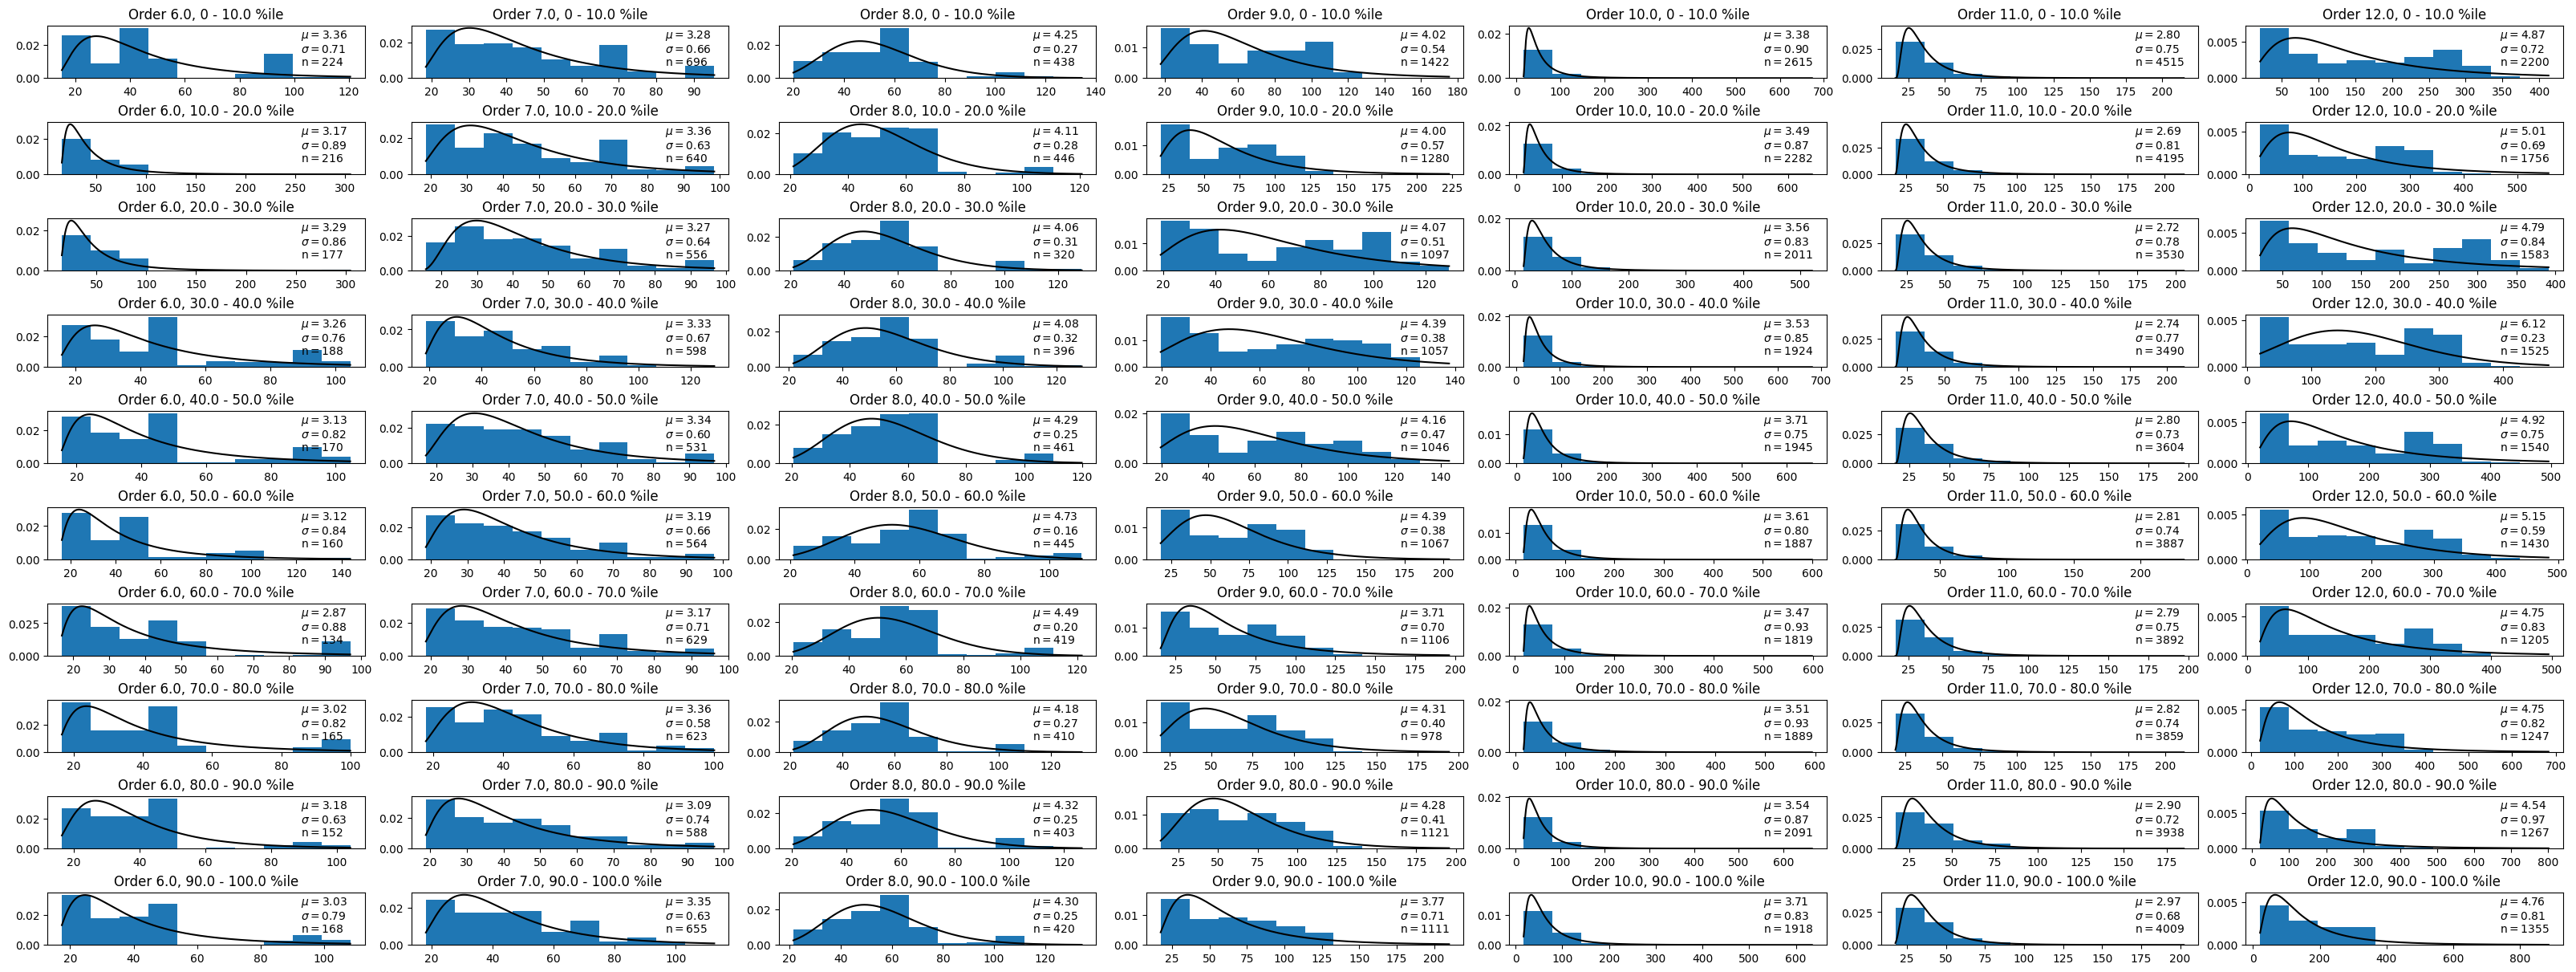

In [130]:
sigmas = []
mus = []
os = []
qs = []

fig, axs = plt.subplots(10, 7, figsize=(32, 12), constrained_layout=True)

for q in range(len(decile_bins) - 1):
    for o in range(len(orders)):
        order = orders[o]
        ax = axs[q, o]
        df = Qw.loc[(Qw.NewSO == order) & (Qw.decile == q)]

        x = np.linspace(min(df.sat_width_m), max(df.sat_width_m), 1000)

        shape, loc, scale = lognorm.fit(df.sat_width_m)
        sigma = shape
        mu = np.log(scale)
        pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)

        sigmas.append(sigma)
        mus.append(mu)
        os.append(order)
        qs.append(q)


        ax.hist(df.sat_width_m, density=True)
        ax.plot(x, pdf_fitted, color='black')

        param_label = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\sigma=%.2f$' % (sigma, ),
            r'$\mathrm{n}=%.0f$' % (len(df) )))
        ax.text(0.8, 0.95, param_label, transform=ax.transAxes, verticalalignment='top')
        ax.set_title(f'Order {order}, {100 * decile_bins[q]} - {100 * decile_bins[q + 1]} %ile')

Text(0.02, 0.5, 'Flow percentile')

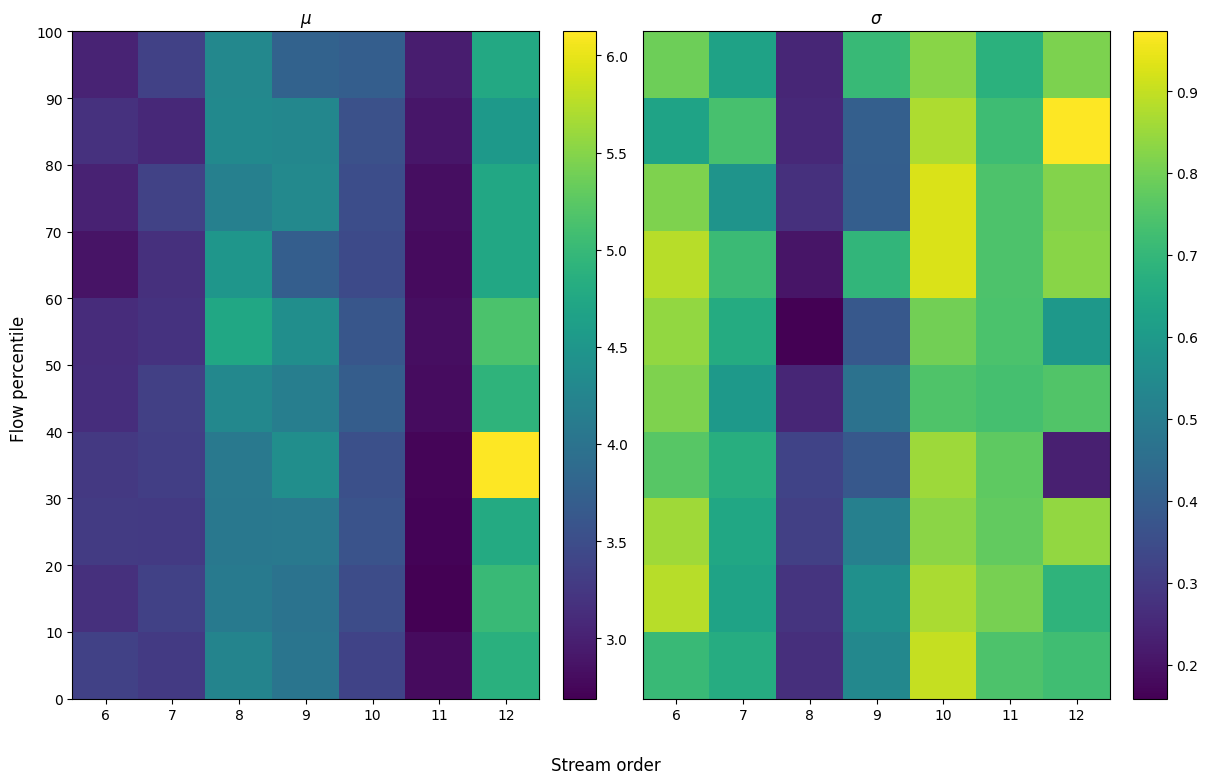

In [172]:
osarray = np.array(os.copy())

osarray.shape = (10, 7)

os_axis = osarray[1]
os_axis = [int(os_axis[o]) for o in range(len(os_axis))]
qsarray = np.array(qs.copy())
qsarray.shape = (10, 7)
qs_axis = qsarray[:, 1]
qs_axis = [int(decile_bins[d] * 100) for d in range(len(decile_bins))]


musarray = np.array(mus.copy())
musarray.shape = (10, 7)

sigmasarray = np.array(sigmas.copy())
sigmasarray.shape = (10, 7)

fig, (mu_img, sigma_img) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 8))
mshow = mu_img.imshow(np.flip(musarray, axis=0))
mu_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
mu_img.set_xticklabels(os_axis)

mu_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
mu_img.set_yticklabels(np.flip(qs_axis))
mu_img.set_title(r'$\mu$')

im_ratio = musarray.shape[0]/musarray.shape[1]

plt.colorbar(mshow, orientation="vertical", fraction=0.05*im_ratio, ax=mu_img, pad=0.05)


sshow = sigma_img.imshow(np.flip(sigmasarray, axis=0))
sigma_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
sigma_img.set_xticklabels(os_axis)

# fig.set_constrained_layout_pads(w_pad=1./72, h_pad=1./72, wspace=0.01, hspace=0.01)

# sigma_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
sigma_img.yaxis.set_visible(False)
sigma_img.set_title(r'$\sigma$')

plt.colorbar(sshow, orientation="vertical", fraction=0.05*im_ratio, ax=sigma_img, pad=0.05)

fig.supxlabel('Stream order')
fig.supylabel('Flow percentile')

In [131]:
(np.flip(os_axis))

array([12, 11, 10,  9,  8,  7,  6])

In [39]:
import matplotlib.colors as mcolors
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=9)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
Qw['decile_color'] = Qw.decile.apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
Qw

Unnamed: 0                    img_id  iindex  n_pixels  \
date       COMID                                                              
2024-01-03 74029238          12  S2A_13TGF_20240103_0_L2A  158552       293   
           74022645          32  S2A_13TEG_20240103_0_L2A   99883       310   
           74022532          37  S2A_13TEG_20240103_0_L2A   86992       759   
           74022647          39  S2A_13TEG_20240103_0_L2A   78407       944   
           74022533          40  S2A_13TEG_20240103_0_L2A   85825      1077   
...                         ...                       ...     ...       ...   
2024-03-10 74029167         444  S2A_14TML_20240310_0_L2A  244511      5647   
           74030651         445  S2A_14TML_20240310_0_L2A  245153      5570   
2024-12-19 74023339         447  S2A_14TPM_20241219_0_L2A   82494      1454   
2024-10-20 74029691         448  S2A_14TQL_20241020_0_L2A  246043       763   
2024-02-18 74029691         451  S2B_15TTF_20240218_0_L2A  246043       760   

                     n_valid  n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                               
2024-01-03 74029238      293       76        0       0             0      57   
           74022645      310       61        0       0             0      59   
           74022532      759       94        0       0             0      91   
           74022647      944      138        0       0             0     100   
           74022533     1077      129        0       0             0     108   
...                      ...      ...      ...     ...           ...     ...   
2024-03-10 74029167     5647     1326        0       0             0     243   
           74030651     5570      767        0       0             0     240   
2024-12-19 74023339     1454      326        0      28             0     124   
2024-10-20 74029691      763      196        0       0             0      90   
2024-02-18 74029691      760      214        0       0             0      90   

                     ...       Qout      Qout_err           crs           lon  \
date       COMID     ...                                                        
2024-01-03 74029238  ...   1.821875  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022645  ...   0.078781  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022532  ...  12.746226  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022647  ...   2.276201  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022533  ...  38.177040  9.969210e+36 -2.147484e+09  9.969210e+36   
...                  ...        ...           ...           ...           ...   
2024-03-10 74029167  ...   0.897539  9.969210e+36 -2.147484e+09  9.969210e+36   
           74030651  ...   0.006511  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-12-19 74023339  ...   0.069348  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-10-20 74029691  ...   0.514775  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-02-18 74029691  ...   1.034266  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  Q_percentile  decile  quintile  quartile  \
date       COMID                                                              
2024-01-03 74029238  9.969210e+36      0.362925       3         1         1   
           74022645  9.969210e+36      0.439969       4         2         1   
           74022532  9.969210e+36      0.533438       5         2         2   
           74022647  9.969210e+36      0.437231       4         2         1   
           74022533  9.969210e+36      0.513101       5         2         2   
...                           ...           ...     ...       ...       ...   
2024-03-10 74029167  9.969210e+36      0.425890       4         2         1   
           74030651  9.969210e+36      0.679312       6         3         2   
2024-12-19 74023339  9.969210e+36      0.245209       2         1         0   
2024-10-20 74029691  9.969210

/tmp/ipython-input-2300024097.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(x, pdf_fitted, color=df.decile_color[0])


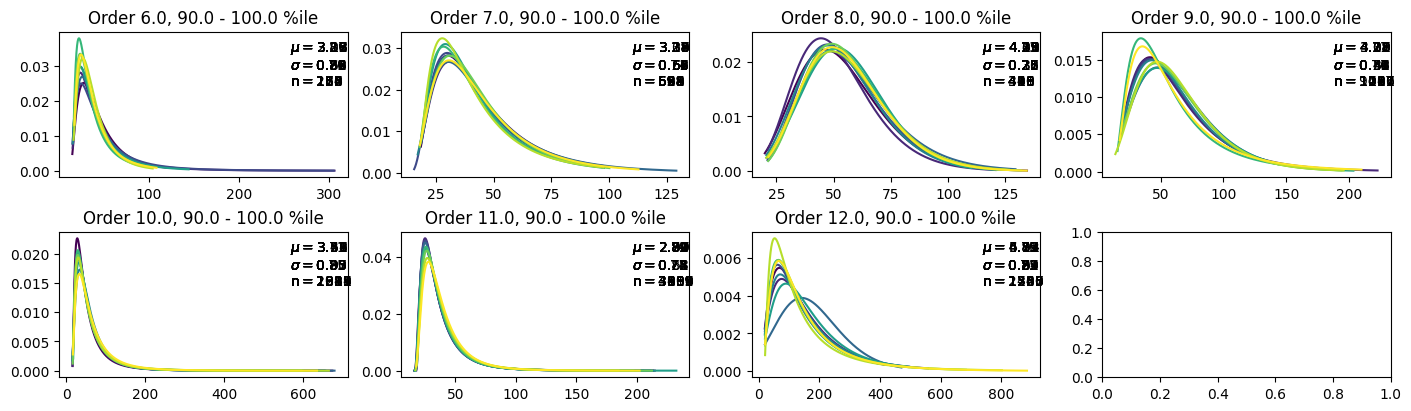

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(14, 4), constrained_layout=True)

for o in range(len(orders)):
    order = orders[o]
    ax = axs.flatten()[o]

    for q in range(len(decile_bins) - 1):
        df = Qw.loc[(Qw.NewSO == order) & (Qw.decile == q)]

        x = np.linspace(min(df.sat_width_m), max(df.sat_width_m), 1000)

        shape, loc, scale = lognorm.fit(df.sat_width_m)
        sigma = shape
        mu = np.log(scale)
        pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)


        # ax.hist(df.sat_width_m, density=True)
        ax.plot(x, pdf_fitted, color=df.decile_color[0])

        param_label = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\sigma=%.2f$' % (sigma, ),
            r'$\mathrm{n}=%.0f$' % (len(df) )))
        ax.text(0.8, 0.95, param_label, transform=ax.transAxes, verticalalignment='top')
        ax.set_title(f'Order {order}, {100 * decile_bins[q]} - {100 * decile_bins[q + 1]} %ile')

In [ ]:
medians = widths_filtered.groupby('iindex')['sat_width_m'].agg('median')

In [ ]:
from scipy.stats import gaussian_kde

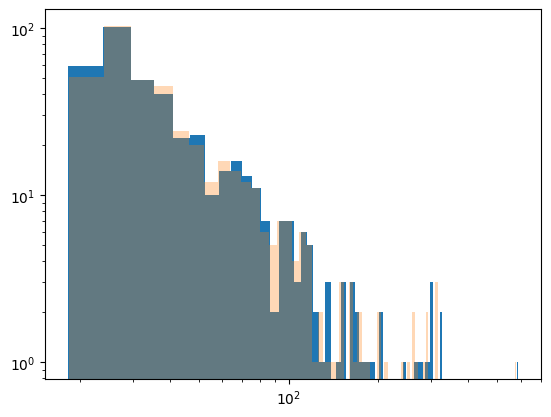

In [ ]:
kde = gaussian_kde(medians)
x_kde = np.linspace(min(medians), max(medians), 100)
kde_values = kde(x_kde)


fig, ax = plt.subplots()
# ax.plot(x_kde, kde_values)
ax.hist(medians, bins=100)
ax.hist(means, bins=100, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

## sanity check... aggregating across stream orders looks like a pareto!!!!!!

In [ ]:
ordermeds = widths_filtered.groupby(['iindex', 'NewSO'])['sat_width_m'].agg('median')

,,sat_width_m
iindex,NewSO,
692,11,92.335726
932,12,235.343519
1082,7,31.575887
1877,7,41.712206
3018,8,31.602672
...,...,...
254274,10,84.373380
255389,12,273.521623
255765,10,204.985763
